# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import matplotlib.pyplot as plt
import json

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
# For Local Machine
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

# # For Udacity Workspace
# !pip -q install ./python
# from unityagents import UnityEnvironment
# env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
# for i in range(1, 10):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         print(actions)
#         print(rewards)
#         print(dones)
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
# #     print(rewards)
# #     print(dones)

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
#MADDPG
def seeding(seed=10):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, full_state_size, full_action_size, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of both agents states
            action_size (int): Dimension of both agents actions
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+full_action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, full_state, full_action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(full_state))
        x = torch.cat((xs, full_action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)


class MADDPG(object):
    '''The main class that defines and trains all the agents'''
    def __init__(self, state_size, action_size, num_agents):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.whole_action_dim = self.action_size*self.num_agents
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE) # Replay memory
        self.maddpg_agents = [DDPG(state_size, action_size, num_agents), DDPG(state_size, action_size, num_agents)] #create agents
        self.episodes_before_training = EPISODES_BEFORE_TRAINING
        
    def reset(self):
        for agent in self.maddpg_agents:
            agent.reset()

    def step(self, i_episode, states, actions, rewards, next_states, dones):
        #for stepping maddpg
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # index 0 is for agent 0 and index 1 is for agent 1
        full_states = np.reshape(states, newshape=(-1))
        full_next_states = np.reshape(next_states, newshape=(-1))
        
        # Save experience / reward
        self.memory.add(full_states, states, actions, rewards, full_next_states, next_states, dones)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and i_episode > self.episodes_before_training:
            for _ in range(NUM_LEARN_STEPS_PER_ENV_STEP): #learn multiple times at every step
                for agent_no in range(self.num_agents):
                    samples = self.memory.sample()
                    self.learn(samples, agent_no, GAMMA)
                self.soft_update_all()

    def soft_update_all(self):
        #soft update all the agents            
        for agent in self.maddpg_agents:
            agent.soft_update_all()
    
    def learn(self, samples, agent_no, gamma):
        #for learning MADDPG
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        critic_full_next_actions = torch.zeros(states.shape[:2] + (self.action_size,), dtype=torch.float, device=DEVICE)
        for agent_id, agent in enumerate(self.maddpg_agents):
            agent_next_state = next_states[:,agent_id,:]
            critic_full_next_actions[:,agent_id,:] = agent.actor_target.forward(agent_next_state)
        critic_full_next_actions = critic_full_next_actions.view(-1, self.whole_action_dim)
        
        agent = self.maddpg_agents[agent_no]
        agent_state = states[:,agent_no,:]
        actor_full_actions = actions.clone() #create a deep copy
        actor_full_actions[:,agent_no,:] = agent.actor_local.forward(agent_state)
        actor_full_actions = actor_full_actions.view(-1, self.whole_action_dim)
                
        full_actions = actions.view(-1,self.whole_action_dim)
        
        agent_rewards = rewards[:,agent_no].view(-1,1) #gives wrong result without doing this
        agent_dones = dones[:,agent_no].view(-1,1) #gives wrong result without doing this
        experiences = (full_states, actor_full_actions, full_actions, agent_rewards, \
                       agent_dones, full_next_states, critic_full_next_actions)
        agent.learn(experiences, gamma)

        #params_delete = list(agent.actor_local.parameters())
        #print(len(params_delete))
        #print(params_delete[2].size())
        #print(params_delete[0][0:3,0:3])
        

    def learn_double_ddpg(self, samples, agent_no, gamma):
        #for learning double ddpg (for debug only, do not use this)
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        temp_agent_no = np.random.randint(0,2) #to decide which agent's experience to use
        strt = temp_agent_no * self.state_size
        stp = strt + self.state_size
        full_states = full_states[:, strt:stp]
        states = states[:,temp_agent_no]
        actions = actions[:,temp_agent_no]
        rewards = rewards[:,temp_agent_no]
        full_next_states = full_next_states[:,strt:stp]
        next_states = next_states[:,temp_agent_no]
        dones = dones[:,temp_agent_no]
        
        
        agent = self.maddpg_agents[agent_no]
        critic_full_next_actions = agent.actor_target.forward(next_states)
        actor_full_actions = agent.actor_local.forward(states)
        full_actions = actions
        
        experiences = (full_states, actor_full_actions, full_actions, rewards, \
                        dones, full_next_states, critic_full_next_actions)
        
        agent.learn(experiences, gamma)

            
    def act(self, full_states, i_episode, add_noise=True):
        # all actions between -1 and 1
        actions = []
        for agent_id, agent in enumerate(self.maddpg_agents):
            action = agent.act(np.reshape(full_states[agent_id,:], newshape=(1,-1)), i_episode, add_noise)
            action = np.reshape(action, newshape=(1,-1))            
            actions.append(action)
        actions = np.concatenate(actions, axis=0)
        return actions

    def save_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_local_' + str(agent_id) + '.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_local_' + str(agent_id) + '.pth')

    def load_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            #Since the model is trained on gpu, need to load all gpu tensors to cpu:
            agent.actor_local.load_state_dict(torch.load('checkpoint_actor_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.critic_local.load_state_dict(torch.load('checkpoint_critic_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))

            agent.noise_scale = NOISE_END #initialize to the final epsilon value upon training


class DDPG(object):
    """Interacts with and learns from the environment.
    There are two agents and the observations of each agent has 24 dimensions. Each agent's action has 2 dimensions.
    Will use two separate actor networks (one for each agent using each agent's observations only and output that agent's action).
    The critic for each agents gets to see the actions and observations of all agents. """
    
    def __init__(self, state_size, action_size, num_agents):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state for each agent
            action_size (int): dimension of each action for each agent
        """
        self.state_size = state_size
        self.action_size = action_size        

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(DEVICE)
        self.actor_target = Actor(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_target = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        self.noise = OUNoise(action_size) #single agent only
        self.noise_scale = NOISE_START
    
        # Make sure target is initialized with the same weight as the source (makes a big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def act(self, states, i_episode, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        if i_episode > EPISODES_BEFORE_TRAINING and self.noise_scale > NOISE_END:
            #self.noise_scale *= NOISE_REDUCTION
            self.noise_scale = NOISE_REDUCTION**(i_episode-EPISODES_BEFORE_TRAINING)
        #else keep the previous value
        
        if not add_noise:
            self.noise_scale = 0.0
                                    
        states = torch.from_numpy(states).float().to(DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise
        actions += self.noise_scale*self.add_noise2() #works much better than OU Noise process
        #actions += self.noise_scale*self.noise.sample()
        
        return np.clip(actions, -1, 1)

    def add_noise2(self):
        noise = 0.5*np.random.randn(1,self.action_size) #sigma of 0.5 as sigma of 1 will have alot of actions just clipped
        return noise
        
        
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        #for MADDPG
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, full_next_states, critic_full_next_actions = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get Q values from target models
        Q_target_next = self.critic_target(full_next_states, critic_full_next_actions)
        # Compute Q targets for current states (y_i)
        Q_target = agent_rewards + gamma * Q_target_next * (1 - agent_dones)
        # Compute critic loss
        Q_expected = self.critic_local(full_states, full_actions)
        critic_loss = F.mse_loss(input=Q_expected, target=Q_target) #target=Q_targets.detach() #not necessary to detach
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actor_loss = -self.critic_local.forward(full_states, actor_full_actions).mean() #-ve b'cse we want to do gradient ascent
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                  

        
        
    def soft_update_all(self):
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)


   
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)


class OUNoise(object):
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
#actions += self.noise.sample()
    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["full_state", "state", "action", "reward", \
                                                                "full_next_state", "next_state", "done"])

    def add(self, full_state, state, action, reward, full_next_state, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(full_state, state, action, reward, full_next_state, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(DEVICE)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        full_next_states = torch.from_numpy(np.array([e.full_next_state for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)

        return (full_states, states, actions, rewards, full_next_states, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [8]:
#Constants
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4 #3e-5 #1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4 #3e-5 #1e-4        # learning rate of the critic
WEIGHT_DECAY_actor = 0.0 #3e-4 #0        # L2 weight decay
WEIGHT_DECAY_critic = 0.0 #1e-6 #0        # L2 weight decay
#to decay exploration as it learns
NOISE_START=1.0
NOISE_END=0.1
NOISE_REDUCTION=0.999
EPISODES_BEFORE_TRAINING = 300
NUM_LEARN_STEPS_PER_ENV_STEP = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seeding(seed=2)
state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]
MADDPG_obj = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)
###MADDPG_obj.load_maddpg() #load the local network weights


#Training
def MADDPG_Training(n_episodes=2500, t_max=1000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    scores_list_100_avg = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        MADDPG_obj.reset() #reset the MADDPG_obj OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent in MADDPG)
        num_steps = 0
        for _ in range(t_max):
            actions = MADDPG_obj.act(states, i_episode)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent in MADDPG)
            rewards = env_info.rewards                         # get rewards (for each agent in MADDPG)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent in MADDPG)
            MADDPG_obj.step(i_episode, states, actions, rewards, next_states, dones) #train the MADDPG_obj           
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
            #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        scores_list_100_avg.append(np.mean(scores_deque))
        
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        print('Episode {}\tAverage Score: {:.2f}\tCurrent Score: {}'.format(i_episode, np.mean(scores_deque), np.max(scores)))
        print('Noise Scaling: {}, Memory size: {} and Num Steps: {}'.format(MADDPG_obj.maddpg_agents[0].noise_scale, len(MADDPG_obj.memory), num_steps))
        
        if i_episode % 500 == 0:
            MADDPG_obj.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 1.0 and len(scores_deque) >= 100:
            MADDPG_obj.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores_list, scores_list_100_avg

Episode 1	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 15 and Num Steps: 15
Episode 2	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 29 and Num Steps: 14
Episode 3	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 43 and Num Steps: 14
Episode 4	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 57 and Num Steps: 14
Episode 5	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 71 and Num Steps: 14
Episode 6	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 86 and Num Steps: 15
Episode 7	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 100 and Num Steps: 14
Episode 8	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 116 and Num Steps: 16
Episode 9	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 130 and Num Steps: 14
Episode 10	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 1.0, 

Episode 82	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1295 and Num Steps: 15
Episode 83	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1309 and Num Steps: 14
Episode 84	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1323 and Num Steps: 14
Episode 85	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1337 and Num Steps: 14
Episode 86	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1351 and Num Steps: 14
Episode 87	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1372 and Num Steps: 21
Episode 88	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1386 and Num Steps: 14
Episode 89	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1400 and Num Steps: 14
Episode 90	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1414 and Num Steps: 14
Episode 91	Average Score: 0.01	Current Score: 

Episode 162	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2621 and Num Steps: 15
Episode 163	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2635 and Num Steps: 14
Episode 164	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2652 and Num Steps: 17
Episode 165	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2666 and Num Steps: 14
Episode 166	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2680 and Num Steps: 14
Episode 167	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2694 and Num Steps: 14
Episode 168	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2708 and Num Steps: 14
Episode 169	Average Score: 0.01	Current Score: 0.10000000149011612
Noise Scaling: 1.0, Memory size: 2761 and Num Steps: 53
Episode 170	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2775 and Num Steps: 14
Episode 171	Average S

Episode 242	Average Score: 0.02	Current Score: 0.20000000298023224
Noise Scaling: 1.0, Memory size: 4229 and Num Steps: 93
Episode 243	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4243 and Num Steps: 14
Episode 244	Average Score: 0.02	Current Score: 0.10000000149011612
Noise Scaling: 1.0, Memory size: 4272 and Num Steps: 29
Episode 245	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4286 and Num Steps: 14
Episode 246	Average Score: 0.02	Current Score: 0.10000000149011612
Noise Scaling: 1.0, Memory size: 4336 and Num Steps: 50
Episode 247	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4350 and Num Steps: 14
Episode 248	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4364 and Num Steps: 14
Episode 249	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4382 and Num Steps: 18
Episode 250	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4396 and Num

Episode 316	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 0.9841194418156399, Memory size: 5432 and Num Steps: 14
Episode 317	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 0.9831353223738244, Memory size: 5446 and Num Steps: 14
Episode 318	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 0.9821521870514505, Memory size: 5460 and Num Steps: 14
Episode 319	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.981170034864399, Memory size: 5475 and Num Steps: 15
Episode 320	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9801888648295347, Memory size: 5489 and Num Steps: 14
Episode 321	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9792086759647052, Memory size: 5503 and Num Steps: 14
Episode 322	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9782294672887404, Memory size: 5517 and Num Steps: 14
Episode 323	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9772512378214517, Memory size: 5531 and Num Steps: 14
Episode 324	Average Score

Episode 384	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.9193926150309794, Memory size: 6398 and Num Steps: 15
Episode 385	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.9184732224159483, Memory size: 6412 and Num Steps: 14
Episode 386	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.9175547491935324, Memory size: 6426 and Num Steps: 14
Episode 387	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.9166371944443389, Memory size: 6440 and Num Steps: 14
Episode 388	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.9157205572498945, Memory size: 6454 and Num Steps: 14
Episode 389	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.9148048366926447, Memory size: 6469 and Num Steps: 15
Episode 390	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.913890031855952, Memory size: 6483 and Num Steps: 14
Episode 391	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.912976141824096, Memory size: 6497 and Num Steps: 14
Episode 392	Average Score:

Episode 452	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8589229565610529, Memory size: 7367 and Num Steps: 14
Episode 453	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8580640336044919, Memory size: 7381 and Num Steps: 14
Episode 454	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8572059695708873, Memory size: 7395 and Num Steps: 14
Episode 455	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8563487636013165, Memory size: 7409 and Num Steps: 14
Episode 456	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8554924148377152, Memory size: 7424 and Num Steps: 15
Episode 457	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8546369224228775, Memory size: 7439 and Num Steps: 15
Episode 458	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8537822855004545, Memory size: 7453 and Num Steps: 14
Episode 459	Average Score: 0.00	Current Score: 0.0
Noise Scaling: 0.8529285032149541, Memory size: 7467 and Num Steps: 14
Episode 460	Average Scor

Episode 519	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.8032337005612523, Memory size: 8474 and Num Steps: 14
Episode 520	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.8024304668606911, Memory size: 8492 and Num Steps: 18
Episode 521	Average Score: 0.01	Current Score: 0.10000000149011612
Noise Scaling: 0.8016280363938304, Memory size: 8524 and Num Steps: 32
Episode 522	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.8008264083574366, Memory size: 8538 and Num Steps: 14
Episode 523	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.8000255819490791, Memory size: 8553 and Num Steps: 15
Episode 524	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.79922555636713, Memory size: 8567 and Num Steps: 14
Episode 525	Average Score: 0.01	Current Score: 0.10000000149011612
Noise Scaling: 0.7984263308107629, Memory size: 8600 and Num Steps: 33
Episode 526	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.7976279044799521, Memory size: 8615 and Num Step

Episode 585	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.7519070284382866, Memory size: 9631 and Num Steps: 14
Episode 586	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.7511551214098483, Memory size: 9645 and Num Steps: 14
Episode 587	Average Score: 0.02	Current Score: 0.10000000149011612
Noise Scaling: 0.7504039662884385, Memory size: 9679 and Num Steps: 34
Episode 588	Average Score: 0.02	Current Score: 0.10000000149011612
Noise Scaling: 0.7496535623221501, Memory size: 9731 and Num Steps: 52
Episode 589	Average Score: 0.02	Current Score: 0.10000000149011612
Noise Scaling: 0.7489039087598279, Memory size: 9764 and Num Steps: 33
Episode 590	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 0.7481550048510681, Memory size: 9779 and Num Steps: 15
Episode 591	Average Score: 0.02	Current Score: 0.10000000149011612
Noise Scaling: 0.747406849846217, Memory size: 9831 and Num Steps: 52
Episode 592	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 0.746659442996370

Episode 648	Average Score: 0.04	Current Score: 0.09000000171363354
Noise Scaling: 0.7059759437435444, Memory size: 11318 and Num Steps: 31
Episode 649	Average Score: 0.04	Current Score: 0.09000000171363354
Noise Scaling: 0.7052699677998009, Memory size: 11350 and Num Steps: 32
Episode 650	Average Score: 0.04	Current Score: 0.10000000149011612
Noise Scaling: 0.704564697832001, Memory size: 11403 and Num Steps: 53
Episode 651	Average Score: 0.04	Current Score: 0.10000000149011612
Noise Scaling: 0.7038601331341691, Memory size: 11436 and Num Steps: 33
Episode 652	Average Score: 0.04	Current Score: 0.10000000149011612
Noise Scaling: 0.7031562730010349, Memory size: 11465 and Num Steps: 29
Episode 653	Average Score: 0.04	Current Score: 0.10000000149011612
Noise Scaling: 0.7024531167280339, Memory size: 11498 and Num Steps: 33
Episode 654	Average Score: 0.04	Current Score: 0.10000000149011612
Noise Scaling: 0.7017506636113058, Memory size: 11531 and Num Steps: 33
Episode 655	Average Score: 0

Episode 709	Average Score: 0.07	Current Score: 0.10000000149011612
Noise Scaling: 0.6641783033340386, Memory size: 13364 and Num Steps: 35
Episode 710	Average Score: 0.07	Current Score: 0.09000000171363354
Noise Scaling: 0.6635141250307046, Memory size: 13394 and Num Steps: 30
Episode 711	Average Score: 0.07	Current Score: 0.09000000171363354
Noise Scaling: 0.6628506109056739, Memory size: 13425 and Num Steps: 31
Episode 712	Average Score: 0.07	Current Score: 0.09000000171363354
Noise Scaling: 0.6621877602947682, Memory size: 13455 and Num Steps: 30
Episode 713	Average Score: 0.07	Current Score: 0.10000000149011612
Noise Scaling: 0.6615255725344734, Memory size: 13508 and Num Steps: 53
Episode 714	Average Score: 0.07	Current Score: 0.09000000171363354
Noise Scaling: 0.660864046961939, Memory size: 13538 and Num Steps: 30
Episode 715	Average Score: 0.07	Current Score: 0.10000000149011612
Noise Scaling: 0.660203182914977, Memory size: 13557 and Num Steps: 19
Episode 716	Average Score: 0.

Episode 770	Average Score: 0.08	Current Score: 0.09000000171363354
Noise Scaling: 0.6248553120386916, Memory size: 15181 and Num Steps: 33
Episode 771	Average Score: 0.08	Current Score: 0.09000000171363354
Noise Scaling: 0.6242304567266529, Memory size: 15211 and Num Steps: 30
Episode 772	Average Score: 0.08	Current Score: 0.09000000171363354
Noise Scaling: 0.6236062262699262, Memory size: 15241 and Num Steps: 30
Episode 773	Average Score: 0.08	Current Score: 0.10000000149011612
Noise Scaling: 0.6229826200436563, Memory size: 15293 and Num Steps: 52
Episode 774	Average Score: 0.08	Current Score: 0.10000000149011612
Noise Scaling: 0.6223596374236127, Memory size: 15326 and Num Steps: 33
Episode 775	Average Score: 0.08	Current Score: 0.09000000171363354
Noise Scaling: 0.621737277786189, Memory size: 15357 and Num Steps: 31
Episode 776	Average Score: 0.08	Current Score: 0.10000000149011612
Noise Scaling: 0.6211155405084029, Memory size: 15390 and Num Steps: 33
Episode 777	Average Score: 0

Episode 831	Average Score: 0.08	Current Score: 0.10000000149011612
Noise Scaling: 0.5878604570836192, Memory size: 16966 and Num Steps: 53
Episode 832	Average Score: 0.08	Current Score: 0.09000000171363354
Noise Scaling: 0.5872725966265356, Memory size: 16995 and Num Steps: 29
Episode 833	Average Score: 0.08	Current Score: 0.10000000149011612
Noise Scaling: 0.586685324029909, Memory size: 17043 and Num Steps: 48
Episode 834	Average Score: 0.08	Current Score: 0.19000000320374966
Noise Scaling: 0.5860986387058792, Memory size: 17109 and Num Steps: 66
Episode 835	Average Score: 0.08	Current Score: 0.09000000171363354
Noise Scaling: 0.5855125400671732, Memory size: 17139 and Num Steps: 30
Episode 836	Average Score: 0.08	Current Score: 0.0
Noise Scaling: 0.5849270275271061, Memory size: 17153 and Num Steps: 14
Episode 837	Average Score: 0.08	Current Score: 0.10000000149011612
Noise Scaling: 0.584342100499579, Memory size: 17185 and Num Steps: 32
Episode 838	Average Score: 0.08	Current Score

Episode 891	Average Score: 0.09	Current Score: 0.10000000149011612
Noise Scaling: 0.5536095095627307, Memory size: 19339 and Num Steps: 30
Episode 892	Average Score: 0.09	Current Score: 0.09000000171363354
Noise Scaling: 0.553055900053168, Memory size: 19370 and Num Steps: 31
Episode 893	Average Score: 0.09	Current Score: 0.10000000149011612
Noise Scaling: 0.5525028441531148, Memory size: 19403 and Num Steps: 33
Episode 894	Average Score: 0.09	Current Score: 0.10000000149011612
Noise Scaling: 0.5519503413089617, Memory size: 19436 and Num Steps: 33
Episode 895	Average Score: 0.09	Current Score: 0.10000000149011612
Noise Scaling: 0.5513983909676528, Memory size: 19469 and Num Steps: 33
Episode 896	Average Score: 0.10	Current Score: 0.10000000149011612
Noise Scaling: 0.5508469925766851, Memory size: 19501 and Num Steps: 32
Episode 897	Average Score: 0.10	Current Score: 0.10000000149011612
Noise Scaling: 0.5502961455841084, Memory size: 19532 and Num Steps: 31
Episode 898	Average Score: 0

Episode 951	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.5213541502668073, Memory size: 21670 and Num Steps: 33
Episode 952	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.5208327961165404, Memory size: 21702 and Num Steps: 32
Episode 953	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.520311963320424, Memory size: 21753 and Num Steps: 51
Episode 954	Average Score: 0.11	Current Score: 0.09000000171363354
Noise Scaling: 0.5197916513571035, Memory size: 21783 and Num Steps: 30
Episode 955	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.5192718597057464, Memory size: 21817 and Num Steps: 34
Episode 956	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.5187525878460406, Memory size: 21847 and Num Steps: 30
Episode 957	Average Score: 0.11	Current Score: 0.0
Noise Scaling: 0.5182338352581947, Memory size: 21861 and Num Steps: 14
Episode 958	Average Score: 0.10	Current Scor

Episode 1011	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.49097810876679904, Memory size: 24364 and Num Steps: 40
Episode 1012	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.49048713065803223, Memory size: 24415 and Num Steps: 51
Episode 1013	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.4899966435273742, Memory size: 24460 and Num Steps: 45
Episode 1014	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.4895066468838468, Memory size: 24512 and Num Steps: 52
Episode 1015	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.48901714023696297, Memory size: 24564 and Num Steps: 52
Episode 1016	Average Score: 0.11	Current Score: 0.10000000149011612
Noise Scaling: 0.488528123096726, Memory size: 24597 and Num Steps: 33
Episode 1017	Average Score: 0.11	Current Score: 0.20000000298023224
Noise Scaling: 0.4880395949736293, Memory size: 24666 and Num Steps: 69
Episode 1018	Avera

Episode 1071	Average Score: 0.12	Current Score: 0.09000000171363354
Noise Scaling: 0.46237188898344544, Memory size: 27479 and Num Steps: 30
Episode 1072	Average Score: 0.12	Current Score: 0.10000000149011612
Noise Scaling: 0.461909517094462, Memory size: 27532 and Num Steps: 53
Episode 1073	Average Score: 0.12	Current Score: 0.10000000149011612
Noise Scaling: 0.4614476075773675, Memory size: 27580 and Num Steps: 48
Episode 1074	Average Score: 0.12	Current Score: 0.10000000149011612
Noise Scaling: 0.46098615996979014, Memory size: 27610 and Num Steps: 30
Episode 1075	Average Score: 0.12	Current Score: 0.10000000149011612
Noise Scaling: 0.46052517380982033, Memory size: 27640 and Num Steps: 30
Episode 1076	Average Score: 0.12	Current Score: 0.0
Noise Scaling: 0.46006464863601054, Memory size: 27655 and Num Steps: 15
Episode 1077	Average Score: 0.12	Current Score: 0.2900000046938658
Noise Scaling: 0.4596045839873745, Memory size: 27760 and Num Steps: 105
Episode 1078	Average Score: 0.12	

Episode 1131	Average Score: 0.12	Current Score: 0.10000000149011612
Noise Scaling: 0.43543237448833555, Memory size: 30223 and Num Steps: 37
Episode 1132	Average Score: 0.12	Current Score: 0.0
Noise Scaling: 0.4349969421138472, Memory size: 30241 and Num Steps: 18
Episode 1133	Average Score: 0.12	Current Score: 0.30000000447034836
Noise Scaling: 0.43456194517173335, Memory size: 30350 and Num Steps: 109
Episode 1134	Average Score: 0.12	Current Score: 0.20000000298023224
Noise Scaling: 0.43412738322656164, Memory size: 30422 and Num Steps: 72
Episode 1135	Average Score: 0.12	Current Score: 0.30000000447034836
Noise Scaling: 0.43369325584333507, Memory size: 30557 and Num Steps: 135
Episode 1136	Average Score: 0.12	Current Score: 0.09000000171363354
Noise Scaling: 0.4332595625874917, Memory size: 30588 and Num Steps: 31
Episode 1137	Average Score: 0.12	Current Score: 0.20000000298023224
Noise Scaling: 0.43282630302490427, Memory size: 30659 and Num Steps: 71
Episode 1138	Average Score: 0

Episode 1191	Average Score: 0.12	Current Score: 0.0
Noise Scaling: 0.4100624568016039, Memory size: 33890 and Num Steps: 20
Episode 1192	Average Score: 0.13	Current Score: 0.30000000447034836
Noise Scaling: 0.40965239434480233, Memory size: 34016 and Num Steps: 126
Episode 1193	Average Score: 0.12	Current Score: 0.10000000149011612
Noise Scaling: 0.4092427419504575, Memory size: 34046 and Num Steps: 30
Episode 1194	Average Score: 0.12	Current Score: 0.0
Noise Scaling: 0.40883349920850703, Memory size: 34060 and Num Steps: 14
Episode 1195	Average Score: 0.12	Current Score: 0.20000000298023224
Noise Scaling: 0.40842466570929853, Memory size: 34150 and Num Steps: 90
Episode 1196	Average Score: 0.13	Current Score: 0.20000000298023224
Noise Scaling: 0.40801624104358925, Memory size: 34244 and Num Steps: 94
Episode 1197	Average Score: 0.13	Current Score: 0.10000000149011612
Noise Scaling: 0.40760822480254566, Memory size: 34275 and Num Steps: 31
Episode 1198	Average Score: 0.12	Current Score

Episode 1251	Average Score: 0.15	Current Score: 0.20000000298023224
Noise Scaling: 0.3861706853463918, Memory size: 37951 and Num Steps: 75
Episode 1252	Average Score: 0.15	Current Score: 0.4000000059604645
Noise Scaling: 0.38578451466104546, Memory size: 38112 and Num Steps: 161
Episode 1253	Average Score: 0.15	Current Score: 0.10000000149011612
Noise Scaling: 0.38539873014638437, Memory size: 38149 and Num Steps: 37
Episode 1254	Average Score: 0.15	Current Score: 0.20000000298023224
Noise Scaling: 0.385013331416238, Memory size: 38220 and Num Steps: 71
Episode 1255	Average Score: 0.15	Current Score: 0.30000000447034836
Noise Scaling: 0.3846283180848218, Memory size: 38328 and Num Steps: 108
Episode 1256	Average Score: 0.16	Current Score: 0.10000000149011612
Noise Scaling: 0.38424368976673695, Memory size: 38378 and Num Steps: 50
Episode 1257	Average Score: 0.16	Current Score: 0.10000000149011612
Noise Scaling: 0.3838594460769702, Memory size: 38442 and Num Steps: 64
Episode 1258	Aver

Episode 1310	Average Score: 0.18	Current Score: 0.0
Noise Scaling: 0.36403497277104124, Memory size: 42381 and Num Steps: 17
Episode 1311	Average Score: 0.18	Current Score: 0.2900000046938658
Noise Scaling: 0.3636709377982702, Memory size: 42487 and Num Steps: 106
Episode 1312	Average Score: 0.18	Current Score: 0.10000000149011612
Noise Scaling: 0.36330726686047193, Memory size: 42538 and Num Steps: 51
Episode 1313	Average Score: 0.18	Current Score: 0.10000000149011612
Noise Scaling: 0.3629439595936115, Memory size: 42571 and Num Steps: 33
Episode 1314	Average Score: 0.18	Current Score: 0.0
Noise Scaling: 0.36258101563401784, Memory size: 42585 and Num Steps: 14
Episode 1315	Average Score: 0.18	Current Score: 0.10000000149011612
Noise Scaling: 0.3622184346183838, Memory size: 42637 and Num Steps: 52
Episode 1316	Average Score: 0.17	Current Score: 0.0
Noise Scaling: 0.36185621618376546, Memory size: 42651 and Num Steps: 14
Episode 1317	Average Score: 0.17	Current Score: 0.10000000149011

Episode 1369	Average Score: 0.16	Current Score: 0.20000000298023224
Noise Scaling: 0.34316810267859177, Memory size: 46315 and Num Steps: 68
Episode 1370	Average Score: 0.16	Current Score: 0.3900000061839819
Noise Scaling: 0.3428249345759132, Memory size: 46459 and Num Steps: 144
Episode 1371	Average Score: 0.16	Current Score: 0.5000000074505806
Noise Scaling: 0.3424821096413373, Memory size: 46665 and Num Steps: 206
Episode 1372	Average Score: 0.16	Current Score: 0.0
Noise Scaling: 0.3421396275316959, Memory size: 46698 and Num Steps: 33
Episode 1373	Average Score: 0.16	Current Score: 0.10000000149011612
Noise Scaling: 0.34179748790416425, Memory size: 46749 and Num Steps: 51
Episode 1374	Average Score: 0.16	Current Score: 0.20000000298023224
Noise Scaling: 0.34145569041626006, Memory size: 46839 and Num Steps: 90
Episode 1375	Average Score: 0.16	Current Score: 0.20000000298023224
Noise Scaling: 0.3411142347258438, Memory size: 46907 and Num Steps: 68
Episode 1376	Average Score: 0.16	

Episode 1429	Average Score: 0.15	Current Score: 0.10000000149011612
Noise Scaling: 0.3231738463307534, Memory size: 50192 and Num Steps: 51
Episode 1430	Average Score: 0.15	Current Score: 0.20000000298023224
Noise Scaling: 0.3228506724844226, Memory size: 50286 and Num Steps: 94
Episode 1431	Average Score: 0.15	Current Score: 0.10000000149011612
Noise Scaling: 0.32252782181193823, Memory size: 50316 and Num Steps: 30
Episode 1432	Average Score: 0.15	Current Score: 0.10000000149011612
Noise Scaling: 0.32220529399012626, Memory size: 50372 and Num Steps: 56
Episode 1433	Average Score: 0.15	Current Score: 0.19000000320374966
Noise Scaling: 0.32188308869613613, Memory size: 50440 and Num Steps: 68
Episode 1434	Average Score: 0.15	Current Score: 0.10000000149011612
Noise Scaling: 0.32156120560744, Memory size: 50470 and Num Steps: 30
Episode 1435	Average Score: 0.15	Current Score: 0.10000000149011612
Noise Scaling: 0.32123964440183256, Memory size: 50492 and Num Steps: 22
Episode 1436	Avera

Episode 1488	Average Score: 0.19	Current Score: 0.10000000149011612
Noise Scaling: 0.3046491792710793, Memory size: 55666 and Num Steps: 51
Episode 1489	Average Score: 0.19	Current Score: 0.19000000320374966
Noise Scaling: 0.30434453009180823, Memory size: 55745 and Num Steps: 79
Episode 1490	Average Score: 0.19	Current Score: 0.10000000149011612
Noise Scaling: 0.3040401855617164, Memory size: 55776 and Num Steps: 31
Episode 1491	Average Score: 0.19	Current Score: 0.2900000046938658
Noise Scaling: 0.3037361453761547, Memory size: 55881 and Num Steps: 105
Episode 1492	Average Score: 0.19	Current Score: 0.30000000447034836
Noise Scaling: 0.3034324092307785, Memory size: 56006 and Num Steps: 125
Episode 1493	Average Score: 0.19	Current Score: 0.20000000298023224
Noise Scaling: 0.30312897682154777, Memory size: 56077 and Num Steps: 71
Episode 1494	Average Score: 0.19	Current Score: 0.30000000447034836
Noise Scaling: 0.3028258478447262, Memory size: 56187 and Num Steps: 110
Episode 1495	Ave

Episode 1547	Average Score: 0.24	Current Score: 0.6000000089406967
Noise Scaling: 0.287186365741844, Memory size: 61190 and Num Steps: 224
Episode 1548	Average Score: 0.24	Current Score: 0.20000000298023224
Noise Scaling: 0.2868991793761021, Memory size: 61280 and Num Steps: 90
Episode 1549	Average Score: 0.24	Current Score: 0.4000000059604645
Noise Scaling: 0.286612280196726, Memory size: 61441 and Num Steps: 161
Episode 1550	Average Score: 0.24	Current Score: 0.4000000059604645
Noise Scaling: 0.2863256679165293, Memory size: 61589 and Num Steps: 148
Episode 1551	Average Score: 0.24	Current Score: 0.10000000149011612
Noise Scaling: 0.28603934224861277, Memory size: 61642 and Num Steps: 53
Episode 1552	Average Score: 0.24	Current Score: 0.5000000074505806
Noise Scaling: 0.28575330290636414, Memory size: 61829 and Num Steps: 187
Episode 1553	Average Score: 0.25	Current Score: 0.7000000104308128
Noise Scaling: 0.28546754960345777, Memory size: 62112 and Num Steps: 283
Episode 1554	Averag

Episode 1606	Average Score: 0.24	Current Score: 0.0
Noise Scaling: 0.2707245391743542, Memory size: 67059 and Num Steps: 14
Episode 1607	Average Score: 0.23	Current Score: 0.30000000447034836
Noise Scaling: 0.2704538146351798, Memory size: 67190 and Num Steps: 131
Episode 1608	Average Score: 0.23	Current Score: 0.19000000320374966
Noise Scaling: 0.27018336082054467, Memory size: 67257 and Num Steps: 67
Episode 1609	Average Score: 0.23	Current Score: 0.5000000074505806
Noise Scaling: 0.2699131774597241, Memory size: 67458 and Num Steps: 201
Episode 1610	Average Score: 0.23	Current Score: 0.4000000059604645
Noise Scaling: 0.26964326428226437, Memory size: 67639 and Num Steps: 181
Episode 1611	Average Score: 0.24	Current Score: 0.4000000059604645
Noise Scaling: 0.2693736210179821, Memory size: 67785 and Num Steps: 146
Episode 1612	Average Score: 0.23	Current Score: 0.10000000149011612
Noise Scaling: 0.26910424739696415, Memory size: 67838 and Num Steps: 53
Episode 1613	Average Score: 0.23

Episode 1665	Average Score: 0.25	Current Score: 0.0
Noise Scaling: 0.25520632193608206, Memory size: 73986 and Num Steps: 14
Episode 1666	Average Score: 0.25	Current Score: 0.19000000320374966
Noise Scaling: 0.25495111561414596, Memory size: 74056 and Num Steps: 70
Episode 1667	Average Score: 0.25	Current Score: 0.4000000059604645
Noise Scaling: 0.25469616449853183, Memory size: 74227 and Num Steps: 171
Episode 1668	Average Score: 0.26	Current Score: 0.7000000104308128
Noise Scaling: 0.2544414683340333, Memory size: 74502 and Num Steps: 275
Episode 1669	Average Score: 0.26	Current Score: 0.30000000447034836
Noise Scaling: 0.2541870268656993, Memory size: 74613 and Num Steps: 111
Episode 1670	Average Score: 0.26	Current Score: 0.20000000298023224
Noise Scaling: 0.2539328398388336, Memory size: 74684 and Num Steps: 71
Episode 1671	Average Score: 0.27	Current Score: 0.490000007674098
Noise Scaling: 0.2536789069989947, Memory size: 74877 and Num Steps: 193
Episode 1672	Average Score: 0.27	

Episode 1724	Average Score: 0.33	Current Score: 0.20000000298023224
Noise Scaling: 0.24057762534114957, Memory size: 81948 and Num Steps: 89
Episode 1725	Average Score: 0.33	Current Score: 0.6000000089406967
Noise Scaling: 0.24033704771580844, Memory size: 82171 and Num Steps: 223
Episode 1726	Average Score: 0.32	Current Score: 0.10000000149011612
Noise Scaling: 0.24009671066809263, Memory size: 82201 and Num Steps: 30
Episode 1727	Average Score: 0.33	Current Score: 0.4000000059604645
Noise Scaling: 0.23985661395742452, Memory size: 82365 and Num Steps: 164
Episode 1728	Average Score: 0.33	Current Score: 0.30000000447034836
Noise Scaling: 0.2396167573434671, Memory size: 82488 and Num Steps: 123
Episode 1729	Average Score: 0.33	Current Score: 0.20000000298023224
Noise Scaling: 0.23937714058612364, Memory size: 82558 and Num Steps: 70
Episode 1730	Average Score: 0.32	Current Score: 0.5000000074505806
Noise Scaling: 0.23913776344553753, Memory size: 82752 and Num Steps: 194
Episode 1731	

Episode 1783	Average Score: 0.37	Current Score: 0.800000011920929
Noise Scaling: 0.22678746112442438, Memory size: 90411 and Num Steps: 318
Episode 1784	Average Score: 0.37	Current Score: 0.20000000298023224
Noise Scaling: 0.22656067366329993, Memory size: 90481 and Num Steps: 70
Episode 1785	Average Score: 0.37	Current Score: 0.6000000089406967
Noise Scaling: 0.22633411298963665, Memory size: 90729 and Num Steps: 248
Episode 1786	Average Score: 0.37	Current Score: 0.10000000149011612
Noise Scaling: 0.22610777887664701, Memory size: 90781 and Num Steps: 52
Episode 1787	Average Score: 0.37	Current Score: 0.6000000089406967
Noise Scaling: 0.22588167109777035, Memory size: 91010 and Num Steps: 229
Episode 1788	Average Score: 0.38	Current Score: 0.6000000089406967
Noise Scaling: 0.22565578942667258, Memory size: 91231 and Num Steps: 221
Episode 1789	Average Score: 0.38	Current Score: 0.20000000298023224
Noise Scaling: 0.22543013363724593, Memory size: 91298 and Num Steps: 67
Episode 1790	A

Episode 1842	Average Score: 0.44	Current Score: 0.7000000104308128
Noise Scaling: 0.21378776372211958, Memory size: 100000 and Num Steps: 290
Episode 1843	Average Score: 0.44	Current Score: 0.10000000149011612
Noise Scaling: 0.21357397595839747, Memory size: 100000 and Num Steps: 52
Episode 1844	Average Score: 0.44	Current Score: 0.10000000149011612
Noise Scaling: 0.21336040198243905, Memory size: 100000 and Num Steps: 30
Episode 1845	Average Score: 0.45	Current Score: 1.0000000149011612
Noise Scaling: 0.21314704158045664, Memory size: 100000 and Num Steps: 372
Episode 1846	Average Score: 0.45	Current Score: 0.6000000089406967
Noise Scaling: 0.21293389453887618, Memory size: 100000 and Num Steps: 224
Episode 1847	Average Score: 0.46	Current Score: 1.5000000223517418
Noise Scaling: 0.2127209606443373, Memory size: 100000 and Num Steps: 567
Episode 1848	Average Score: 0.46	Current Score: 0.20000000298023224
Noise Scaling: 0.21250823968369295, Memory size: 100000 and Num Steps: 65
Episode

Episode 1900	Average Score: 0.44	Current Score: 1.700000025331974
Noise Scaling: 0.20173495769715533, Memory size: 100000 and Num Steps: 687
Episode 1901	Average Score: 0.44	Current Score: 0.19000000320374966
Noise Scaling: 0.20153322273945817, Memory size: 100000 and Num Steps: 69
Episode 1902	Average Score: 0.44	Current Score: 0.19000000320374966
Noise Scaling: 0.20133168951671873, Memory size: 100000 and Num Steps: 69
Episode 1903	Average Score: 0.45	Current Score: 0.800000011920929
Noise Scaling: 0.201130357827202, Memory size: 100000 and Num Steps: 327
Episode 1904	Average Score: 0.45	Current Score: 0.7000000104308128
Noise Scaling: 0.2009292274693748, Memory size: 100000 and Num Steps: 277
Episode 1905	Average Score: 0.43	Current Score: 0.10000000149011612
Noise Scaling: 0.2007282982419054, Memory size: 100000 and Num Steps: 30
Episode 1906	Average Score: 0.43	Current Score: 0.10000000149011612
Noise Scaling: 0.20052756994366353, Memory size: 100000 and Num Steps: 30
Episode 1907

Episode 1959	Average Score: 0.49	Current Score: 0.30000000447034836
Noise Scaling: 0.1901712963177858, Memory size: 100000 and Num Steps: 147
Episode 1960	Average Score: 0.50	Current Score: 0.800000011920929
Noise Scaling: 0.189981125021468, Memory size: 100000 and Num Steps: 344
Episode 1961	Average Score: 0.50	Current Score: 0.19000000320374966
Noise Scaling: 0.18979114389644655, Memory size: 100000 and Num Steps: 69
Episode 1962	Average Score: 0.50	Current Score: 0.20000000298023224
Noise Scaling: 0.1896013527525501, Memory size: 100000 and Num Steps: 67
Episode 1963	Average Score: 0.49	Current Score: 0.10000000149011612
Noise Scaling: 0.18941175139979755, Memory size: 100000 and Num Steps: 52
Episode 1964	Average Score: 0.49	Current Score: 0.0
Noise Scaling: 0.18922233964839774, Memory size: 100000 and Num Steps: 14
Episode 1965	Average Score: 0.49	Current Score: 0.2900000046938658
Noise Scaling: 0.18903311730874936, Memory size: 100000 and Num Steps: 107
Episode 1966	Average Score

Episode 2018	Average Score: 0.51	Current Score: 1.8000000268220901
Noise Scaling: 0.17927047625269885, Memory size: 100000 and Num Steps: 695
Episode 2019	Average Score: 0.51	Current Score: 1.1000000163912773
Noise Scaling: 0.17909120577644613, Memory size: 100000 and Num Steps: 414
Episode 2020	Average Score: 0.50	Current Score: 0.10000000149011612
Noise Scaling: 0.1789121145706697, Memory size: 100000 and Num Steps: 52
Episode 2021	Average Score: 0.51	Current Score: 0.7000000104308128
Noise Scaling: 0.17873320245609903, Memory size: 100000 and Num Steps: 281
Episode 2022	Average Score: 0.53	Current Score: 2.600000038743019
Noise Scaling: 0.1785544692536429, Memory size: 100000 and Num Steps: 1000
Episode 2023	Average Score: 0.54	Current Score: 0.6000000089406967
Noise Scaling: 0.17837591478438927, Memory size: 100000 and Num Steps: 229
Episode 2024	Average Score: 0.54	Current Score: 0.30000000447034836
Noise Scaling: 0.17819753886960488, Memory size: 100000 and Num Steps: 106
Episode

Episode 2077	Average Score: 0.84	Current Score: 0.7000000104308128
Noise Scaling: 0.16899450273591973, Memory size: 100000 and Num Steps: 259
Episode 2078	Average Score: 0.84	Current Score: 0.30000000447034836
Noise Scaling: 0.16882550823318382, Memory size: 100000 and Num Steps: 131
Episode 2079	Average Score: 0.84	Current Score: 0.30000000447034836
Noise Scaling: 0.16865668272495063, Memory size: 100000 and Num Steps: 109
Episode 2080	Average Score: 0.84	Current Score: 0.0
Noise Scaling: 0.16848802604222568, Memory size: 100000 and Num Steps: 15
Episode 2081	Average Score: 0.85	Current Score: 2.0000000298023224
Noise Scaling: 0.16831953801618346, Memory size: 100000 and Num Steps: 780
Episode 2082	Average Score: 0.85	Current Score: 0.490000007674098
Noise Scaling: 0.16815121847816727, Memory size: 100000 and Num Steps: 181
Episode 2083	Average Score: 0.84	Current Score: 0.20000000298023224
Noise Scaling: 0.16798306725968912, Memory size: 100000 and Num Steps: 71
Episode 2084	Average 

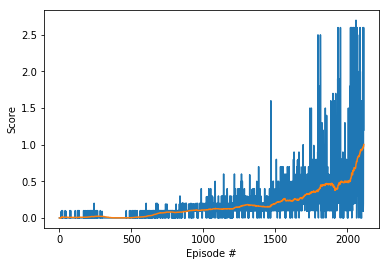

In [8]:
#Use active_session() on Udacity workspace
from workspace_utils import active_session

with active_session():
    # do long-running work here
    scores, scores_avg = MADDPG_Training()
    with open("scores_file.json", "w") as write_file:
        json.dump((scores, scores_avg), write_file)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.plot(np.arange(1, len(scores)+1), scores_avg)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

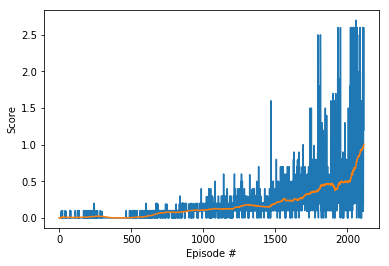

In [9]:
#plot scores
with open("scores_file.json", "r") as read_file:
    scores, scores_avg = json.load(read_file)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Inference
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seeding()
state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]
MADDPG_obj = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)
MADDPG_obj.load_maddpg() #load the local network weights

scores_list = []
def MADDPG_Inference(n_episodes=3, t_max=1000):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        MADDPG_obj.reset() #reset the MADDPG_obj OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent in MADDPG_obj)
        for _ in range(t_max):
            actions = MADDPG_obj.act(states, i_episode=0, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent in MADDPG_obj)
            rewards = env_info.rewards                         # get rewards (for each agent in MADDPG_obj)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent in MADDPG_obj)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {}'.format(i_episode, scores))
        scores_list.append(np.max(scores))
    print('Mean score is: ', np.mean(np.array(scores_list)))

MADDPG_Inference()

In [12]:
env.close()